<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [4]:
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX.pkl", "rb"))
diab_train_reduced = pickle.load(open("diab_train_reduced.pkl", "rb"))
diabetes_train = pickle.load(open("diabetes_train.pkl", "rb"))
diab_train_target = diabetes_train['diabetes_mellitus']


from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(diab_train_reduced, diab_train_target, test_size=0.2)

In [5]:
#PCA

# Apply standardization before applying PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(KNN_imputed_trainX)

#choose 95 percent variance
pca = PCA(.95)

principalComponents = pca.fit_transform(scaled)
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,6.453654,-0.124940,1.715929,1.376199,0.127811,-1.544863,-0.943325,-0.625683,-0.347078,-0.518018,-0.393827,-0.791423,0.504079,1.230818,0.925587,-0.172595,-0.540586,-0.047707,0.141115,-0.177149,-0.487931,0.189674,0.422424,0.505668,-0.548907,-0.759368,1.156012,-0.829990,0.723546,0.175003,0.227893,0.170217,-0.187924,0.152160,0.126131,-0.193666,0.535371,-0.491040,-0.118507,-0.224551,0.087037,-0.086055,-0.090477,0.211984,0.379573,-0.244864,0.651727
1,-0.062326,0.653641,-0.260169,2.637122,-1.976577,-0.581342,-1.480121,-1.915381,-2.415038,-0.038363,1.406015,0.810995,0.469248,-1.124282,-1.323123,-0.375370,-0.635981,-0.121530,-0.693991,0.075138,-1.203133,-3.565386,-2.870858,5.237815,3.306685,0.598638,-1.213865,1.481505,-3.409733,3.937683,-1.416899,1.718918,1.244218,1.109791,-0.396222,-0.927205,0.776885,-0.715738,-0.386711,0.081647,0.303789,-0.761158,-0.289949,-0.956799,0.624907,0.241129,0.551286
2,2.421293,-0.230210,-0.472388,1.814024,1.851991,-0.384713,0.949781,0.203183,-0.354816,3.538618,-0.883414,0.640330,0.135814,-1.951169,0.557603,-1.972717,1.975454,0.628498,-1.030620,-1.648400,-0.065594,1.102985,-0.038092,-1.718759,-0.738591,1.020790,-0.393326,0.029044,-0.488185,2.158134,-0.500474,0.247300,1.377898,0.337070,0.117190,-0.423748,-1.366180,0.371532,-0.521923,-0.649570,0.274783,-0.037178,-0.340070,0.450197,0.223998,-0.137971,0.735386
3,4.981869,5.724887,0.502870,0.454054,-1.383911,-1.450540,2.728581,-0.401877,-2.569764,-0.974639,-0.533537,-1.130587,1.613806,1.686383,1.400542,0.168744,-1.788367,-0.663016,-1.141189,0.055848,1.922724,-0.110849,-0.246639,-0.025334,-0.405940,1.789753,0.044286,-0.228616,-0.012068,0.035040,-0.693689,1.000449,-0.236316,0.342052,-0.397238,-0.386082,-0.736717,-1.358647,0.034855,-1.210304,-0.088982,0.293725,0.927425,0.451620,0.144796,0.494821,-0.937337
4,-1.369405,0.578419,-0.144901,0.720835,1.744186,-1.992898,-0.757273,0.361912,-0.420951,-1.480273,-1.455759,0.118268,-0.558454,-1.229049,0.283049,-0.159191,-0.280111,-1.115407,-0.402339,1.264674,-0.654688,0.599783,-1.024051,-0.020077,-0.642041,-1.165160,1.762117,-1.072691,0.599317,-0.141622,-0.151874,-1.134277,-0.023933,0.454394,0.379824,0.438502,0.096579,0.045762,0.094877,0.334250,-0.050464,-0.653059,0.492516,-0.704059,0.412444,1.245708,-0.184646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104120,-0.431280,1.321322,-1.671019,0.721509,-0.803646,-0.766984,1.311059,0.996032,1.571368,1.522628,1.087875,1.146873,-2.830835,-0.202050,-0.384699,0.594818,-1.619842,0.699384,0.548433,0.993100,0.280278,-1.058855,-0.044274,-0.207569,-0.931715,0.036779,1.227660,1.589541,0.494418,-0.863401,-0.404822,1.235106,0.279781,0.831660,0.482175,0.314015,-0.307587,-0.094304,-0.374266,0.051003,-0.159757,0.405798,1.470608,-0.382817,1.961101,0.244283,-0.586483
104121,1.664125,-0.560021,-1.568482,0.413955,-0.557733,-1.789151,1.224566,0.071034,0.105631,-2.057026,0.178449,-0.978486,-0.293493,-0.824943,-0.259782,1.171258,0.594767,-0.391171,-0.711993,0.736567,0.870126,-0.275685,-1.534397,-1.739757,0.554246,-0.036247,1.455922,-0.611632,-1.173347,-0.753877,0.235925,-0.194543,0.340152,-0.449881,0.734941,0.464585,0.069037,0.029421,-0.178180,-0.240325,0.423026,0.146496,0.758493,0.260416,-0.692861,-0.310657,0.115748
104122,-0.454621,-3.037832,2.200538,-1.109048,1.469699,0.268322,0.450298,0.231883,-0.548698,-0.424047,-0.041842,0.389006,0.007158,1.323294,2.991858,-0.289085,-0.513337,-0.272808,0.505574,0.268665,-0.895506,-0.396923,0.744719,-0.038847,-0.184916,-1.248771,-0.113700,0.189668,0.366614,1.423153,0.870411,-0.279240,-0.251637,0.239536,0.593839,0.753122,0.491696,0.018653,-0.034597,0.352866,-0.343035,0.222399,0.523706,-0.040316,-0.294167,0.059949,0.041834
104123,0.215137,6.683496,-2.660214,-0.773192,2.439693,2.836173,1.27679

In [7]:
#Run in a loop with different PCA (n_components) with LogisticRegression to see scores
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,5):
		steps = [('norm', StandardScaler()),('pca', PCA(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, KNN_imputed_trainX, train_y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>1 0.784 (0.000)
>2 0.784 (0.000)
>3 0.784 (0.000)
>4 0.784 (0.000)


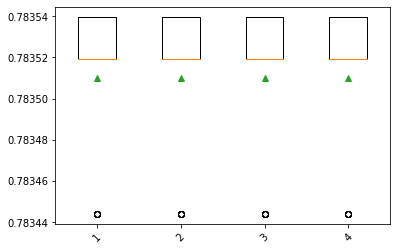

In [8]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

### Based on above, logistic regression may not be the correct model.
### As shown in the plot, getting the same score for different n_components values.

In [15]:
#Run in a loop with different PCA (n_components) with LogisticRegression to see scores
# get a list of models to evaluate
def get_knn_models():
	models = dict()
	for i in range(1,4):
		steps = [('norm', StandardScaler()),('pca', PCA(n_components=i)), ('m', KNeighborsClassifier(n_neighbors=3))]
		models[str(i)] = Pipeline(steps=steps)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_knn_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, KNN_imputed_trainX, train_y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>1 0.716 (0.003)
>2 0.716 (0.003)
>3 0.715 (0.003)


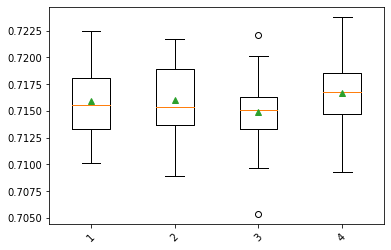

In [13]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()